محمد علی قهاری - **810100201**

In [1]:
import torch
import numpy as np
import os
import cv2 as cv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as img
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

In [2]:
!pip install torchinfo

In [3]:
import random
import os
import glob
import time
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import torch.optim.lr_scheduler as lr_scheduler

from torch import nn
from torch.utils.data import (Dataset, DataLoader)

from torchvision import transforms
from torchinfo import summary

from PIL import Image
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple
# from scikitplot.metrics import plot_roc

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, top_k_accuracy_score, f1_score,
    matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
)

In [4]:
from google.colab import drive
import pickle
drive.mount('/AI/')
# drive.mount('/content/drive')
# os.chdir('/content/drive/My Drive/CA5-CNN')

Mounted at /AI/


In [5]:
TRANSFORM_PROB = .5

In [6]:
class CustomDataSet(torch.utils.data.Dataset):
    FILE_SIZE = 512
    DATA_PATH = '/AI/MyDrive/AI'
    # DATA_PATH = './AI-CA5-Dataset'
    classes = ['notumor', 'glioma', 'meningioma', 'pituitary']

    def __len__(self):
        return len(self.x_test if self.is_test else self.x_train)

    def __getitem__(self, idx):
        im = cv.imread(self.x_test[idx] if self.is_test else self.x_train[idx])
        im = cv.resize(im, (512, 512))
        if self.norm:
            im = cv.normalize(im, None, 0, 1.0, cv.NORM_MINMAX, dtype=cv.CV_32F)
        im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
        if self.transforms:
            return self.transforms(torch.tensor(im, dtype=torch.float32).reshape(shape=(1,512,512))), self.y_test[idx] if self.is_test else self.y_train[idx]
        else:
            return torch.tensor(im, dtype=torch.float32).reshape(shape=(1,512,512)), self.y_test[idx] if self.is_test else self.y_train[idx]

    def get_sample(self, mode):
        return [i[0] for i in self.data if i[1] == mode][0]

    def split(self, percent):
        for c in range(len(self.classes)):
            x=[d[0] for d in self.data if d[1] == c]
            y=[c]*len(x)
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=percent, shuffle=True)
            self.x_train+=x_train
            self.y_train+=y_train
            self.x_test+=x_test
            self.y_test+=y_test
        print(len(self.x_train),len(self.x_test),len(self.y_train),len(self.y_test))

    def __init__(self, transforms, norm, is_test) -> None:
        self.x_train=[]
        self.y_train=[]
        self.x_test=[]
        self.y_test=[]
        self.is_test = is_test
        super(CustomDataSet, self)
        self.transforms = transforms
        self.norm = norm
        self.data=[]
        for folder in os.listdir(self.DATA_PATH):
            path = os.path.join(self.DATA_PATH, folder)
            for file in os.listdir(path):
                self.data.append((os.path.join(path, file), torch.tensor(self.classes.index(folder), dtype=torch.int8)))

Normalization will help our algorithm to train better. The reason we typically want normalized pixel values is because neural networks rely on gradient calculations. These networks are trying to learn how important or how weighty a certain pixel should be in determining the class of an image. Normalizing the pixel values helps these gradient calculations stay consistent, and not get so large that they slow down or prevent a network from training.

In [7]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30,),
    transforms.ToTensor()
])

# Only reshape test data
test_transforms = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

In [8]:
transform = transforms.Compose([
    transforms.RandomVerticalFlip(TRANSFORM_PROB),
    transforms.RandomHorizontalFlip(TRANSFORM_PROB),
    transforms.RandomRotation(180)])
data = CustomDataSet(transform, True, False)
# with open('/AI/MyDrive/variables.data', 'wb') as f:
#     pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

# with open('/AI/MyDrive/variables.data', 'rb') as f:
#   data = pickle.load(f)

In [9]:
test = CustomDataSet(transform, True, True)
# with open('/AI/MyDrive/variables.test', 'wb') as f:
#     pickle.dump(test, f, pickle.HIGHEST_PROTOCOL)

The training set data must be large enough to capture variability in the data but not so large that the model overfits the training data. The optimal split ratio depends on various factors. The rough standard for train-validation-test splits is 60-80% training data, 10-20% validation data, and 10-20% test data.

1048 263 1048 263
1048 263 1048 263


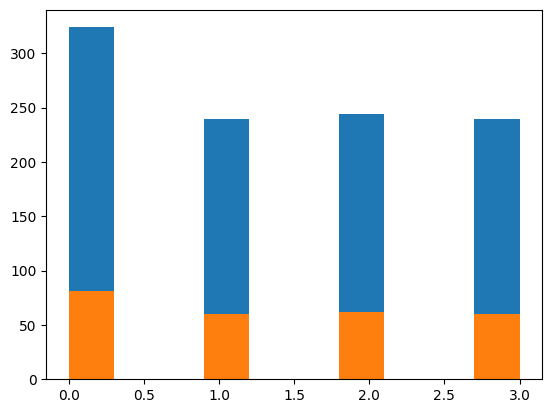

In [10]:
data.split(.2)
test.split(.2)
plt.hist(data.y_train)
plt.hist(data.y_test)
plt.show()

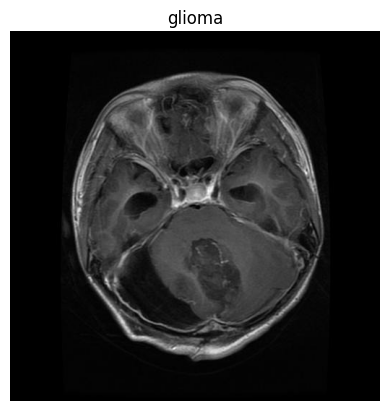

In [11]:
res = data.get_sample(2)
image = cv.imread(res)
imgplot = plt.imshow(image)
plt.title('meningioma')
plt.axis("off")
plt.show()
res = data.get_sample(0)
image = cv.imread(res)
imgplot = plt.imshow(image)
plt.title('notumor')
plt.axis("off")
plt.show()
res = data.get_sample(1)
image = cv.imread(res)
imgplot = plt.imshow(image)
plt.title('glioma')
plt.axis("off")
plt.show()
res = data.get_sample(3)
image = cv.imread(res)
imgplot = plt.imshow(image)
plt.title('pituitary')
plt.axis("off")
plt.show()

In [12]:
batch_size = 32
keep_prob = 1

Batch size in data loader is a parameter that controls how many records are processed in a single operation. It can affect the speed, memory usage, and accuracy of the data loading process. Depending on the type of data loader and the type of operation, the batch size can have different default values and limits.

In [13]:
data_loader = torch.utils.data.DataLoader(dataset=data,batch_size=batch_size,shuffle=True)

•  Kernel_size: This is the size of the filter that slides over the input data. It affects the receptive field and the number of parameters of the convolution layer. A larger kernel_size can capture more spatial information and reduce the dimensionality of the output, but it can also increase the computation cost and the risk of overfitting. A smaller kernel_size can preserve more details and allow for deeper networks, but it can also increase the number of parameters and the risk of underfitting.

A common choice is 3 × 3, which offers a good balance between performance and complexity.

•  Padding: This is the amount of zeros added around the input data to preserve the spatial dimensions of the output. It affects the border effect and the size of the output. Padding can help avoid losing information at the edges of the input and maintain the resolution of the output, but it can also introduce noise and redundancy.
A common choice is 'same', which means the output has the same size as the input.

•  Stride: This is the number of pixels that the filter moves at each step. It affects the sampling rate and the size of the output. A larger stride can reduce the computation cost and the number of parameters of the convolution layer, but it can also lose some information and reduce the resolution of the output. A smaller stride can preserve more information and increase the resolution of the output, but it can also increase the computation cost and the number of parameters. A common choice is 1, which means the filter moves one pixel at a time.

•  The number of filters should be a multiple of a power of two, such as 16, 32, 64, etc. This is mainly for computational efficiency, as some hardware and software implementations can optimize the operations for powers of two.

---



Loss functions are used to measure the discrepancy between the predictions of a deep learning model and the true labels of the data. Different loss functions have different properties and are suitable for different types of problems. Here are some common loss functions and their applications:

•  Mean squared error (MSE): This is the average of the squared differences between the predictions and the labels. It is often used for regression problems, where the output is a continuous value. MSE is sensitive to outliers and large errors.

•  Cross-entropy (CE): This is the negative logarithm of the probability that the model assigns to the correct label. It is often used for classification problems, where the output is a discrete value or a probability distribution. CE encourages the model to increase the probability of the correct label and decrease the probability of the incorrect labels.

•  Focal loss (FL): This is a modified version of CE that reduces the contribution of easy examples and increases the contribution of hard examples. It is often used for imbalanced classification problems, where some classes are much more frequent than others. FL helps the model to focus on the minority classes and avoid being dominated by the majority classes.

•  Hamming loss (HL): This is the fraction of labels that are incorrectly predicted by the model. It is often used for multi-label classification problems, where each example can have multiple labels. HL counts the number of mismatches between the predictions and the labels, regardless of their magnitude or probability.

•  Huber loss (HL): This is a combination of MSE and mean absolute error (MAE). It uses MSE for small errors and MAE for large errors. It is often used for robust regression problems, where the output is a continuous value and there are outliers or noise in the data. HL is less sensitive to outliers and large errors than MSE, but more stable than MAE.

•  Ranking loss (RL): This is the difference between the scores of relevant and irrelevant examples. It is often used for ranking or retrieval problems, where the output is a list of items sorted by relevance or similarity. RL encourages the model to assign higher scores to relevant items and lower scores to irrelevant items.

•  SparseMax loss (SL): This is a generalization of CE that allows the model to output sparse probability distributions. It is often used for multi-class classification problems, where the output is a discrete value or a probability distribution. SL encourages the model to assign zero probability to irrelevant classes and non-zero probability to relevant classes.

**from above loss functions only SL and CE are practical for our problem and from those CE is better because of :**

SL is a generalization of CE that reduces the loss when the predicted probability distribution is sparse. SL can be seen as a combination of CE and a sparsity-inducing penalty term. SL has the same gradient as CE when the predicted probabilities are non-zero, but has a different gradient when the predicted probabilities are zero. This gradient encourages the model to output sparse probabilities and focus on the relevant classes.

** our model is not encouraged in zero probabilities!**

---


Activation functions are functions that are applied to the output of a neuron in a neural network. They determine whether the neuron should be activated or not, and how much signal it should pass on to the next layer. Activation functions also introduce non-linearity to the network, which enables it to learn complex and nonlinear patterns from the data.

•  Sigmoid: This function maps the input to a value between 0 and 1, which can be interpreted as a probability. It is often used for binary classification problems, where the output is either 0 or 1.  However, it also has some drawbacks, such as being prone to vanishing gradients, saturation, and output imbalance.

•  Tanh: This function maps the input to a value between -1 and 1, which can be seen as a scaled version of the sigmoid function. It is often used for hidden layers, as it has a zero-centered output, which can help with the learning process. However, it also suffers from vanishing gradients and saturation.

•  ReLU: This function maps the input to a value between 0 and the input itself, which means that it outputs zero for negative inputs and preserves positive inputs. It is often used for hidden layers, as it is simple, fast, and sparse. However, it also has some drawbacks, such as being prone to dying neurons, unbounded output, and undefined gradients at zero.

In [14]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 512, 512, 1)
        # Conv -> (?, 512, 512, 32)
        # Pool -> (?, 256, 256, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='same'),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same'),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 32, kernel_size=3, stride=1, padding='same'),
            torch.nn.ReLU(),
            # torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))

        self.fc1 = torch.nn.Linear(64 * 64 * 32, 256, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight) # initialize parameters
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))

        self.fc2 = torch.nn.Linear(256, 4, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        # out = torch.flatten(out)  # Flatten them for FC
        # out = self.fc1(out)
        out = self.layer4(out)
        out = self.fc2(out)
        out = torch.nn.functional.log_softmax(out,dim=1)
        return out

•  Stochastic gradient descent (SGD): This is a variant of GD that updates the parameters using a random subset of the data (a mini-batch) instead of the whole data. This reduces the computation time and the variance of the gradient. SGD can escape local minima or saddle points, but it can also oscillate around the optimal point.
•  Adam: This is an optimizer that combines the advantages of momentum and RMSprop. It uses an exponentially weighted average of the gradients and the squared gradients to adjust the learning rate and the direction of the parameter updates. Adam can handle sparse and noisy gradients, non-stationary objectives, and high-dimensional problems, but it requires tuning the decay rates and the initial learning rate.

exponentially weighted average of the gradients is a concept related to some optimization algorithms for gradient descent, such as RMSprop and Adam. It means that instead of keeping track of the sum of all the past squared gradients, which can grow very large and make the learning rate too small, these algorithms use a weighted average that gives more importance to the recent gradients and less importance to the old ones. This way, the learning rate can adapt to the changing landscape of the loss function and avoid getting stuck in local minima or saddle points.

**I choose to use Adam because this is better for :**

1- Adam can converge faster than SGD, as it uses adaptive learning rates and momentum to accelerate the gradient descent process
2- Adam can handle sparse and noisy gradients, non-stationary objectives, and high-dimensional problems better than SGD

**disadvantages over SGD :**

•  Adam can fail to converge to an optimal solution or generalize well, as it can overshoot the optimal point or get stuck in a flat region of the loss function

•  Adam can be less stable and more prone to oscillations than SGD, as it uses exponential moving averages that can fluctuate over time

In [15]:
model = CNN()
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()    # Softmax is internally computed.
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

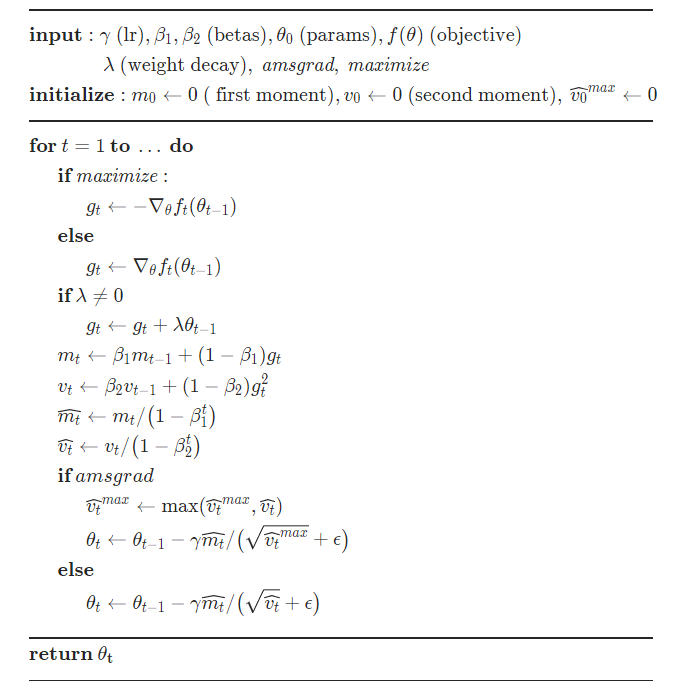

In [16]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.cuda()

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=131072, out_features=256, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=131072, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=256, out_features=4, bias=True)
)

In [17]:
from torch.autograd import Variable
print('Training the Deep Learning network ...')
train_cost = []
train_accu = []

training_epochs = 15
# training_epochs = 1
total_batch = len(data) // batch_size

# print('Size of the training dataset is {}'.format(data.data.size()))
print('Batch size is : {}'.format(batch_size))
print('Total number of batches is : {0:2.0f}'.format(total_batch))
print('\nTotal number of epochs is : {0:2.0f}'.format(training_epochs))

for epoch in range(training_epochs):
    avg_cost = 0
    for i, (batch_X, batch_Y) in enumerate(tqdm(data_loader)):
        X = Variable(batch_X).to('cuda')    # image is already size of (28x28), no reshape
        Y = Variable(batch_Y).to('cuda')   # label is not one-hot encoded

        optimizer.zero_grad() # <= initialization of the gradients

        # forward propagation
        hypothesis = model.forward(X)
        cost = criterion(hypothesis, Y) # <= compute the loss function

        # Backward propagation
        cost.backward() # <= compute the gradient of the loss/cost function
        optimizer.step() # <= Update the gradients

        # Print some performance to monitor the training
        prediction = hypothesis.data.max(dim=1)[1]
        train_accu.append(((prediction.data == Y.data).float().mean()).item())
        train_cost.append(cost.item())
        if i % 2 == 0:
            print("Epoch= {},\t batch = {},\t cost = {:2.4f},\t accuracy = {}".format(epoch+1, i, train_cost[-1], train_accu[-1]))

        avg_cost += cost.data / total_batch

    print("[Epoch: {:>4}], averaged cost = {:>.9}".format(epoch + 1, avg_cost.item()))


print('Learning Finished!')

Training the Deep Learning network ...
Batch size is : 32
Total number of batches is : 32

Total number of epochs is : 15


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch= 1,	 batch = 0,	 cost = 1.3838,	 accuracy = 0.375
Epoch= 1,	 batch = 2,	 cost = 3.3135,	 accuracy = 0.125
Epoch= 1,	 batch = 4,	 cost = 1.2944,	 accuracy = 0.375
Epoch= 1,	 batch = 6,	 cost = 1.4524,	 accuracy = 0.1875
Epoch= 1,	 batch = 8,	 cost = 1.3499,	 accuracy = 0.1875
Epoch= 1,	 batch = 10,	 cost = 1.2661,	 accuracy = 0.21875
Epoch= 1,	 batch = 12,	 cost = 1.2500,	 accuracy = 0.3125
Epoch= 1,	 batch = 14,	 cost = 1.1210,	 accuracy = 0.4375
Epoch= 1,	 batch = 16,	 cost = 1.0959,	 accuracy = 0.34375
Epoch= 1,	 batch = 18,	 cost = 1.0636,	 accuracy = 0.5
Epoch= 1,	 batch = 20,	 cost = 1.2039,	 accuracy = 0.40625
Epoch= 1,	 batch = 22,	 cost = 1.0277,	 accuracy = 0.5
Epoch= 1,	 batch = 24,	 cost = 0.9283,	 accuracy = 0.6875
Epoch= 1,	 batch = 26,	 cost = 1.1272,	 accuracy = 0.59375
Epoch= 1,	 batch = 28,	 cost = 1.0213,	 accuracy = 0.6875
Epoch= 1,	 batch = 30,	 cost = 1.1108,	 accuracy = 0.5
Epoch= 1,	 batch = 32,	 cost = 1.2312,	 accuracy = 0.5416666865348816
[Epoch:    1], 

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch= 2,	 batch = 0,	 cost = 0.8214,	 accuracy = 0.71875
Epoch= 2,	 batch = 2,	 cost = 1.0925,	 accuracy = 0.5
Epoch= 2,	 batch = 4,	 cost = 1.0313,	 accuracy = 0.53125
Epoch= 2,	 batch = 6,	 cost = 1.0459,	 accuracy = 0.53125
Epoch= 2,	 batch = 8,	 cost = 0.9528,	 accuracy = 0.59375
Epoch= 2,	 batch = 10,	 cost = 1.1466,	 accuracy = 0.53125
Epoch= 2,	 batch = 12,	 cost = 1.1569,	 accuracy = 0.4375
Epoch= 2,	 batch = 14,	 cost = 0.9717,	 accuracy = 0.65625
Epoch= 2,	 batch = 16,	 cost = 0.8424,	 accuracy = 0.625
Epoch= 2,	 batch = 18,	 cost = 1.1413,	 accuracy = 0.65625
Epoch= 2,	 batch = 20,	 cost = 1.1184,	 accuracy = 0.625
Epoch= 2,	 batch = 22,	 cost = 0.9045,	 accuracy = 0.625
Epoch= 2,	 batch = 24,	 cost = 0.9384,	 accuracy = 0.65625
Epoch= 2,	 batch = 26,	 cost = 1.0125,	 accuracy = 0.59375
Epoch= 2,	 batch = 28,	 cost = 0.9543,	 accuracy = 0.6875
Epoch= 2,	 batch = 30,	 cost = 1.0633,	 accuracy = 0.53125
Epoch= 2,	 batch = 32,	 cost = 0.9899,	 accuracy = 0.5833333730697632
[Ep

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch= 3,	 batch = 0,	 cost = 1.0529,	 accuracy = 0.53125
Epoch= 3,	 batch = 2,	 cost = 0.9132,	 accuracy = 0.59375
Epoch= 3,	 batch = 4,	 cost = 0.7862,	 accuracy = 0.625
Epoch= 3,	 batch = 6,	 cost = 0.8894,	 accuracy = 0.6875
Epoch= 3,	 batch = 8,	 cost = 0.9150,	 accuracy = 0.59375
Epoch= 3,	 batch = 10,	 cost = 0.9119,	 accuracy = 0.625
Epoch= 3,	 batch = 12,	 cost = 0.9576,	 accuracy = 0.5625
Epoch= 3,	 batch = 14,	 cost = 0.9050,	 accuracy = 0.65625
Epoch= 3,	 batch = 16,	 cost = 0.8859,	 accuracy = 0.65625
Epoch= 3,	 batch = 18,	 cost = 1.0306,	 accuracy = 0.59375
Epoch= 3,	 batch = 20,	 cost = 0.9142,	 accuracy = 0.59375
Epoch= 3,	 batch = 22,	 cost = 0.8148,	 accuracy = 0.625
Epoch= 3,	 batch = 24,	 cost = 0.7277,	 accuracy = 0.6875
Epoch= 3,	 batch = 26,	 cost = 0.9417,	 accuracy = 0.65625
Epoch= 3,	 batch = 28,	 cost = 1.1143,	 accuracy = 0.75
Epoch= 3,	 batch = 30,	 cost = 0.8286,	 accuracy = 0.6875
Epoch= 3,	 batch = 32,	 cost = 0.7859,	 accuracy = 0.6666666865348816
[Epo

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch= 4,	 batch = 0,	 cost = 0.8636,	 accuracy = 0.65625
Epoch= 4,	 batch = 2,	 cost = 0.7326,	 accuracy = 0.6875
Epoch= 4,	 batch = 4,	 cost = 1.1834,	 accuracy = 0.4375
Epoch= 4,	 batch = 6,	 cost = 0.7233,	 accuracy = 0.8125
Epoch= 4,	 batch = 8,	 cost = 0.9338,	 accuracy = 0.625
Epoch= 4,	 batch = 10,	 cost = 1.0398,	 accuracy = 0.53125
Epoch= 4,	 batch = 12,	 cost = 0.4970,	 accuracy = 0.90625
Epoch= 4,	 batch = 14,	 cost = 1.1414,	 accuracy = 0.5625
Epoch= 4,	 batch = 16,	 cost = 0.8139,	 accuracy = 0.59375
Epoch= 4,	 batch = 18,	 cost = 0.7014,	 accuracy = 0.6875
Epoch= 4,	 batch = 20,	 cost = 0.7652,	 accuracy = 0.6875
Epoch= 4,	 batch = 22,	 cost = 0.7686,	 accuracy = 0.75
Epoch= 4,	 batch = 24,	 cost = 0.9652,	 accuracy = 0.59375
Epoch= 4,	 batch = 26,	 cost = 0.9046,	 accuracy = 0.65625
Epoch= 4,	 batch = 28,	 cost = 1.0743,	 accuracy = 0.5
Epoch= 4,	 batch = 30,	 cost = 0.7614,	 accuracy = 0.75
Epoch= 4,	 batch = 32,	 cost = 0.6376,	 accuracy = 0.7083333730697632
[Epoch:  

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch= 5,	 batch = 0,	 cost = 0.9242,	 accuracy = 0.65625
Epoch= 5,	 batch = 2,	 cost = 0.9943,	 accuracy = 0.6875
Epoch= 5,	 batch = 4,	 cost = 0.8380,	 accuracy = 0.65625
Epoch= 5,	 batch = 6,	 cost = 0.6384,	 accuracy = 0.78125
Epoch= 5,	 batch = 8,	 cost = 0.9566,	 accuracy = 0.5
Epoch= 5,	 batch = 10,	 cost = 0.7850,	 accuracy = 0.6875
Epoch= 5,	 batch = 12,	 cost = 0.6667,	 accuracy = 0.71875
Epoch= 5,	 batch = 14,	 cost = 0.8353,	 accuracy = 0.6875
Epoch= 5,	 batch = 16,	 cost = 0.5270,	 accuracy = 0.84375
Epoch= 5,	 batch = 18,	 cost = 0.8937,	 accuracy = 0.65625
Epoch= 5,	 batch = 20,	 cost = 0.8006,	 accuracy = 0.75
Epoch= 5,	 batch = 22,	 cost = 0.7753,	 accuracy = 0.625
Epoch= 5,	 batch = 24,	 cost = 0.6375,	 accuracy = 0.71875
Epoch= 5,	 batch = 26,	 cost = 0.7140,	 accuracy = 0.71875
Epoch= 5,	 batch = 28,	 cost = 0.7139,	 accuracy = 0.71875
Epoch= 5,	 batch = 30,	 cost = 0.8692,	 accuracy = 0.71875
Epoch= 5,	 batch = 32,	 cost = 0.7957,	 accuracy = 0.7083333730697632
[Ep

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch= 6,	 batch = 0,	 cost = 0.9068,	 accuracy = 0.59375
Epoch= 6,	 batch = 2,	 cost = 0.8560,	 accuracy = 0.59375
Epoch= 6,	 batch = 4,	 cost = 0.7268,	 accuracy = 0.6875
Epoch= 6,	 batch = 6,	 cost = 0.6825,	 accuracy = 0.71875
Epoch= 6,	 batch = 8,	 cost = 0.8510,	 accuracy = 0.65625
Epoch= 6,	 batch = 10,	 cost = 0.9129,	 accuracy = 0.78125
Epoch= 6,	 batch = 12,	 cost = 0.7105,	 accuracy = 0.78125
Epoch= 6,	 batch = 14,	 cost = 0.5831,	 accuracy = 0.75
Epoch= 6,	 batch = 16,	 cost = 0.7235,	 accuracy = 0.65625
Epoch= 6,	 batch = 18,	 cost = 0.8002,	 accuracy = 0.6875
Epoch= 6,	 batch = 20,	 cost = 0.5448,	 accuracy = 0.8125
Epoch= 6,	 batch = 22,	 cost = 0.5088,	 accuracy = 0.75
Epoch= 6,	 batch = 24,	 cost = 0.8499,	 accuracy = 0.65625
Epoch= 6,	 batch = 26,	 cost = 0.6936,	 accuracy = 0.65625
Epoch= 6,	 batch = 28,	 cost = 0.4710,	 accuracy = 0.84375
Epoch= 6,	 batch = 30,	 cost = 0.7670,	 accuracy = 0.625
Epoch= 6,	 batch = 32,	 cost = 0.7200,	 accuracy = 0.75
[Epoch:    6], a

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch= 7,	 batch = 0,	 cost = 0.6670,	 accuracy = 0.71875
Epoch= 7,	 batch = 2,	 cost = 0.5829,	 accuracy = 0.84375
Epoch= 7,	 batch = 4,	 cost = 0.6368,	 accuracy = 0.75
Epoch= 7,	 batch = 6,	 cost = 0.8376,	 accuracy = 0.8125
Epoch= 7,	 batch = 8,	 cost = 1.0512,	 accuracy = 0.65625
Epoch= 7,	 batch = 10,	 cost = 0.7880,	 accuracy = 0.65625
Epoch= 7,	 batch = 12,	 cost = 0.6555,	 accuracy = 0.75
Epoch= 7,	 batch = 14,	 cost = 0.8306,	 accuracy = 0.6875
Epoch= 7,	 batch = 16,	 cost = 0.8903,	 accuracy = 0.6875
Epoch= 7,	 batch = 18,	 cost = 0.8037,	 accuracy = 0.6875
Epoch= 7,	 batch = 20,	 cost = 1.0855,	 accuracy = 0.625
Epoch= 7,	 batch = 22,	 cost = 0.7161,	 accuracy = 0.625
Epoch= 7,	 batch = 24,	 cost = 0.8444,	 accuracy = 0.625
Epoch= 7,	 batch = 26,	 cost = 0.5542,	 accuracy = 0.75
Epoch= 7,	 batch = 28,	 cost = 0.9610,	 accuracy = 0.53125
Epoch= 7,	 batch = 30,	 cost = 0.5157,	 accuracy = 0.8125
Epoch= 7,	 batch = 32,	 cost = 0.6593,	 accuracy = 0.7916666865348816
[Epoch:    

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch= 8,	 batch = 0,	 cost = 0.6922,	 accuracy = 0.75
Epoch= 8,	 batch = 2,	 cost = 0.6317,	 accuracy = 0.75
Epoch= 8,	 batch = 4,	 cost = 1.0353,	 accuracy = 0.65625
Epoch= 8,	 batch = 6,	 cost = 0.5877,	 accuracy = 0.65625
Epoch= 8,	 batch = 8,	 cost = 0.6155,	 accuracy = 0.75
Epoch= 8,	 batch = 10,	 cost = 0.6096,	 accuracy = 0.75
Epoch= 8,	 batch = 12,	 cost = 0.5902,	 accuracy = 0.8125
Epoch= 8,	 batch = 14,	 cost = 0.6473,	 accuracy = 0.75
Epoch= 8,	 batch = 16,	 cost = 0.9171,	 accuracy = 0.59375
Epoch= 8,	 batch = 18,	 cost = 0.6157,	 accuracy = 0.71875
Epoch= 8,	 batch = 20,	 cost = 0.6689,	 accuracy = 0.78125
Epoch= 8,	 batch = 22,	 cost = 0.6072,	 accuracy = 0.71875
Epoch= 8,	 batch = 24,	 cost = 0.9159,	 accuracy = 0.71875
Epoch= 8,	 batch = 26,	 cost = 0.5265,	 accuracy = 0.78125
Epoch= 8,	 batch = 28,	 cost = 0.7453,	 accuracy = 0.6875
Epoch= 8,	 batch = 30,	 cost = 0.6149,	 accuracy = 0.71875
Epoch= 8,	 batch = 32,	 cost = 0.4192,	 accuracy = 0.8333333730697632
[Epoch: 

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch= 9,	 batch = 0,	 cost = 0.5240,	 accuracy = 0.78125
Epoch= 9,	 batch = 2,	 cost = 0.4777,	 accuracy = 0.84375
Epoch= 9,	 batch = 4,	 cost = 0.7448,	 accuracy = 0.59375
Epoch= 9,	 batch = 6,	 cost = 0.5099,	 accuracy = 0.78125
Epoch= 9,	 batch = 8,	 cost = 0.7416,	 accuracy = 0.65625
Epoch= 9,	 batch = 10,	 cost = 0.5021,	 accuracy = 0.84375
Epoch= 9,	 batch = 12,	 cost = 0.6772,	 accuracy = 0.6875
Epoch= 9,	 batch = 14,	 cost = 0.5291,	 accuracy = 0.75
Epoch= 9,	 batch = 16,	 cost = 0.7482,	 accuracy = 0.71875
Epoch= 9,	 batch = 18,	 cost = 0.5539,	 accuracy = 0.71875
Epoch= 9,	 batch = 20,	 cost = 1.0856,	 accuracy = 0.6875
Epoch= 9,	 batch = 22,	 cost = 0.7838,	 accuracy = 0.59375
Epoch= 9,	 batch = 24,	 cost = 0.7095,	 accuracy = 0.71875
Epoch= 9,	 batch = 26,	 cost = 0.6532,	 accuracy = 0.71875
Epoch= 9,	 batch = 28,	 cost = 0.8307,	 accuracy = 0.625
Epoch= 9,	 batch = 30,	 cost = 0.8904,	 accuracy = 0.71875
Epoch= 9,	 batch = 32,	 cost = 0.6669,	 accuracy = 0.708333373069763

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch= 10,	 batch = 0,	 cost = 0.9931,	 accuracy = 0.53125
Epoch= 10,	 batch = 2,	 cost = 0.6503,	 accuracy = 0.78125
Epoch= 10,	 batch = 4,	 cost = 0.8405,	 accuracy = 0.625
Epoch= 10,	 batch = 6,	 cost = 0.7940,	 accuracy = 0.53125
Epoch= 10,	 batch = 8,	 cost = 0.7478,	 accuracy = 0.625
Epoch= 10,	 batch = 10,	 cost = 0.5575,	 accuracy = 0.75
Epoch= 10,	 batch = 12,	 cost = 0.8843,	 accuracy = 0.59375
Epoch= 10,	 batch = 14,	 cost = 0.7192,	 accuracy = 0.78125
Epoch= 10,	 batch = 16,	 cost = 0.4945,	 accuracy = 0.84375
Epoch= 10,	 batch = 18,	 cost = 0.7669,	 accuracy = 0.6875
Epoch= 10,	 batch = 20,	 cost = 0.4467,	 accuracy = 0.84375
Epoch= 10,	 batch = 22,	 cost = 0.8245,	 accuracy = 0.75
Epoch= 10,	 batch = 24,	 cost = 0.6038,	 accuracy = 0.71875
Epoch= 10,	 batch = 26,	 cost = 0.5365,	 accuracy = 0.75
Epoch= 10,	 batch = 28,	 cost = 0.5169,	 accuracy = 0.84375
Epoch= 10,	 batch = 30,	 cost = 0.8362,	 accuracy = 0.6875
Epoch= 10,	 batch = 32,	 cost = 0.6776,	 accuracy = 0.791666

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch= 11,	 batch = 0,	 cost = 0.4473,	 accuracy = 0.71875
Epoch= 11,	 batch = 2,	 cost = 0.5398,	 accuracy = 0.78125
Epoch= 11,	 batch = 4,	 cost = 0.6622,	 accuracy = 0.625
Epoch= 11,	 batch = 6,	 cost = 0.6425,	 accuracy = 0.6875
Epoch= 11,	 batch = 8,	 cost = 0.6058,	 accuracy = 0.75
Epoch= 11,	 batch = 10,	 cost = 0.3868,	 accuracy = 0.875
Epoch= 11,	 batch = 12,	 cost = 0.8113,	 accuracy = 0.75
Epoch= 11,	 batch = 14,	 cost = 0.7303,	 accuracy = 0.625
Epoch= 11,	 batch = 16,	 cost = 0.6378,	 accuracy = 0.75
Epoch= 11,	 batch = 18,	 cost = 0.4844,	 accuracy = 0.78125
Epoch= 11,	 batch = 20,	 cost = 0.6216,	 accuracy = 0.71875
Epoch= 11,	 batch = 22,	 cost = 0.6166,	 accuracy = 0.8125
Epoch= 11,	 batch = 24,	 cost = 0.4750,	 accuracy = 0.84375
Epoch= 11,	 batch = 26,	 cost = 0.5692,	 accuracy = 0.8125
Epoch= 11,	 batch = 28,	 cost = 0.7340,	 accuracy = 0.65625
Epoch= 11,	 batch = 30,	 cost = 0.5339,	 accuracy = 0.8125
Epoch= 11,	 batch = 32,	 cost = 0.5072,	 accuracy = 0.8333333730

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch= 12,	 batch = 0,	 cost = 0.8193,	 accuracy = 0.625
Epoch= 12,	 batch = 2,	 cost = 0.5628,	 accuracy = 0.75
Epoch= 12,	 batch = 4,	 cost = 0.5034,	 accuracy = 0.71875
Epoch= 12,	 batch = 6,	 cost = 0.5704,	 accuracy = 0.75
Epoch= 12,	 batch = 8,	 cost = 0.7434,	 accuracy = 0.6875
Epoch= 12,	 batch = 10,	 cost = 0.7352,	 accuracy = 0.71875
Epoch= 12,	 batch = 12,	 cost = 0.5383,	 accuracy = 0.8125
Epoch= 12,	 batch = 14,	 cost = 0.5103,	 accuracy = 0.84375
Epoch= 12,	 batch = 16,	 cost = 0.6353,	 accuracy = 0.65625
Epoch= 12,	 batch = 18,	 cost = 0.6444,	 accuracy = 0.75
Epoch= 12,	 batch = 20,	 cost = 0.3877,	 accuracy = 0.875
Epoch= 12,	 batch = 22,	 cost = 0.7249,	 accuracy = 0.65625
Epoch= 12,	 batch = 24,	 cost = 0.3318,	 accuracy = 0.90625
Epoch= 12,	 batch = 26,	 cost = 0.3673,	 accuracy = 0.84375
Epoch= 12,	 batch = 28,	 cost = 0.4223,	 accuracy = 0.84375
Epoch= 12,	 batch = 30,	 cost = 0.6054,	 accuracy = 0.8125
Epoch= 12,	 batch = 32,	 cost = 0.4254,	 accuracy = 0.7916666

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch= 13,	 batch = 0,	 cost = 0.5266,	 accuracy = 0.78125
Epoch= 13,	 batch = 2,	 cost = 0.4878,	 accuracy = 0.78125
Epoch= 13,	 batch = 4,	 cost = 0.3439,	 accuracy = 0.84375
Epoch= 13,	 batch = 6,	 cost = 0.5267,	 accuracy = 0.8125
Epoch= 13,	 batch = 8,	 cost = 0.5850,	 accuracy = 0.78125
Epoch= 13,	 batch = 10,	 cost = 0.4001,	 accuracy = 0.84375
Epoch= 13,	 batch = 12,	 cost = 0.4114,	 accuracy = 0.90625
Epoch= 13,	 batch = 14,	 cost = 0.5174,	 accuracy = 0.78125
Epoch= 13,	 batch = 16,	 cost = 0.5615,	 accuracy = 0.8125
Epoch= 13,	 batch = 18,	 cost = 0.3479,	 accuracy = 0.875
Epoch= 13,	 batch = 20,	 cost = 0.7757,	 accuracy = 0.75
Epoch= 13,	 batch = 22,	 cost = 0.8000,	 accuracy = 0.59375
Epoch= 13,	 batch = 24,	 cost = 0.5862,	 accuracy = 0.8125
Epoch= 13,	 batch = 26,	 cost = 0.5174,	 accuracy = 0.78125
Epoch= 13,	 batch = 28,	 cost = 0.6159,	 accuracy = 0.75
Epoch= 13,	 batch = 30,	 cost = 0.7773,	 accuracy = 0.65625
Epoch= 13,	 batch = 32,	 cost = 0.6297,	 accuracy = 0.79

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch= 14,	 batch = 0,	 cost = 0.7450,	 accuracy = 0.6875
Epoch= 14,	 batch = 2,	 cost = 0.3913,	 accuracy = 0.84375
Epoch= 14,	 batch = 4,	 cost = 0.4884,	 accuracy = 0.84375
Epoch= 14,	 batch = 6,	 cost = 0.4328,	 accuracy = 0.84375
Epoch= 14,	 batch = 8,	 cost = 0.4825,	 accuracy = 0.78125
Epoch= 14,	 batch = 10,	 cost = 0.6087,	 accuracy = 0.75
Epoch= 14,	 batch = 12,	 cost = 0.6522,	 accuracy = 0.71875
Epoch= 14,	 batch = 14,	 cost = 1.0134,	 accuracy = 0.53125
Epoch= 14,	 batch = 16,	 cost = 0.5002,	 accuracy = 0.71875
Epoch= 14,	 batch = 18,	 cost = 0.5407,	 accuracy = 0.78125
Epoch= 14,	 batch = 20,	 cost = 0.3484,	 accuracy = 0.875
Epoch= 14,	 batch = 22,	 cost = 0.6053,	 accuracy = 0.71875
Epoch= 14,	 batch = 24,	 cost = 0.3555,	 accuracy = 0.84375
Epoch= 14,	 batch = 26,	 cost = 0.4423,	 accuracy = 0.875
Epoch= 14,	 batch = 28,	 cost = 0.4286,	 accuracy = 0.90625
Epoch= 14,	 batch = 30,	 cost = 0.7302,	 accuracy = 0.71875
Epoch= 14,	 batch = 32,	 cost = 0.6217,	 accuracy = 0

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch= 15,	 batch = 0,	 cost = 0.5796,	 accuracy = 0.8125
Epoch= 15,	 batch = 2,	 cost = 0.4687,	 accuracy = 0.78125
Epoch= 15,	 batch = 4,	 cost = 0.7606,	 accuracy = 0.71875
Epoch= 15,	 batch = 6,	 cost = 0.6004,	 accuracy = 0.78125
Epoch= 15,	 batch = 8,	 cost = 0.6221,	 accuracy = 0.6875
Epoch= 15,	 batch = 10,	 cost = 0.5667,	 accuracy = 0.75
Epoch= 15,	 batch = 12,	 cost = 0.4453,	 accuracy = 0.75
Epoch= 15,	 batch = 14,	 cost = 0.5180,	 accuracy = 0.75
Epoch= 15,	 batch = 16,	 cost = 0.5096,	 accuracy = 0.78125
Epoch= 15,	 batch = 18,	 cost = 0.5298,	 accuracy = 0.78125
Epoch= 15,	 batch = 20,	 cost = 0.3122,	 accuracy = 0.875
Epoch= 15,	 batch = 22,	 cost = 0.5980,	 accuracy = 0.71875
Epoch= 15,	 batch = 24,	 cost = 0.6084,	 accuracy = 0.78125
Epoch= 15,	 batch = 26,	 cost = 0.6294,	 accuracy = 0.71875
Epoch= 15,	 batch = 28,	 cost = 0.5721,	 accuracy = 0.71875
Epoch= 15,	 batch = 30,	 cost = 0.6639,	 accuracy = 0.75
Epoch= 15,	 batch = 32,	 cost = 0.5318,	 accuracy = 0.75
[Epo

In [18]:
with open('/AI/MyDrive/variables.model', 'wb') as f:
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)
with open('/AI/MyDrive/variables.train_cost', 'wb') as f:
    pickle.dump(train_cost, f, pickle.HIGHEST_PROTOCOL)
with open('/AI/MyDrive/variables.train_accu', 'wb') as f:
    pickle.dump(train_accu, f, pickle.HIGHEST_PROTOCOL)

# # with open('drive/variables.model', 'w') as f:
# #   pickle.dump(model, f)
# # with open('drive/variables.model', 'r') as f:
# #   model = pickle.load(f)

# # with open('drive/variables.train_cost', 'w') as f:
# #   pickle.dump(train_cost, f)
# # with open('drive/variables.train_cost', 'r') as f:
# #   train_cost = pickle.load(f)

# # with open('drive/variables.train_accu', 'w') as f:
# #   pickle.dump(train_accu, f)
# # with open('drive/variables.train_accu', 'r') as f:
# #   train_accu = pickle.load(f)

(<Axes: >, [<matplotlib.lines.Line2D at 0x7c0dcc18a8f0>], (0.0, 100.0))

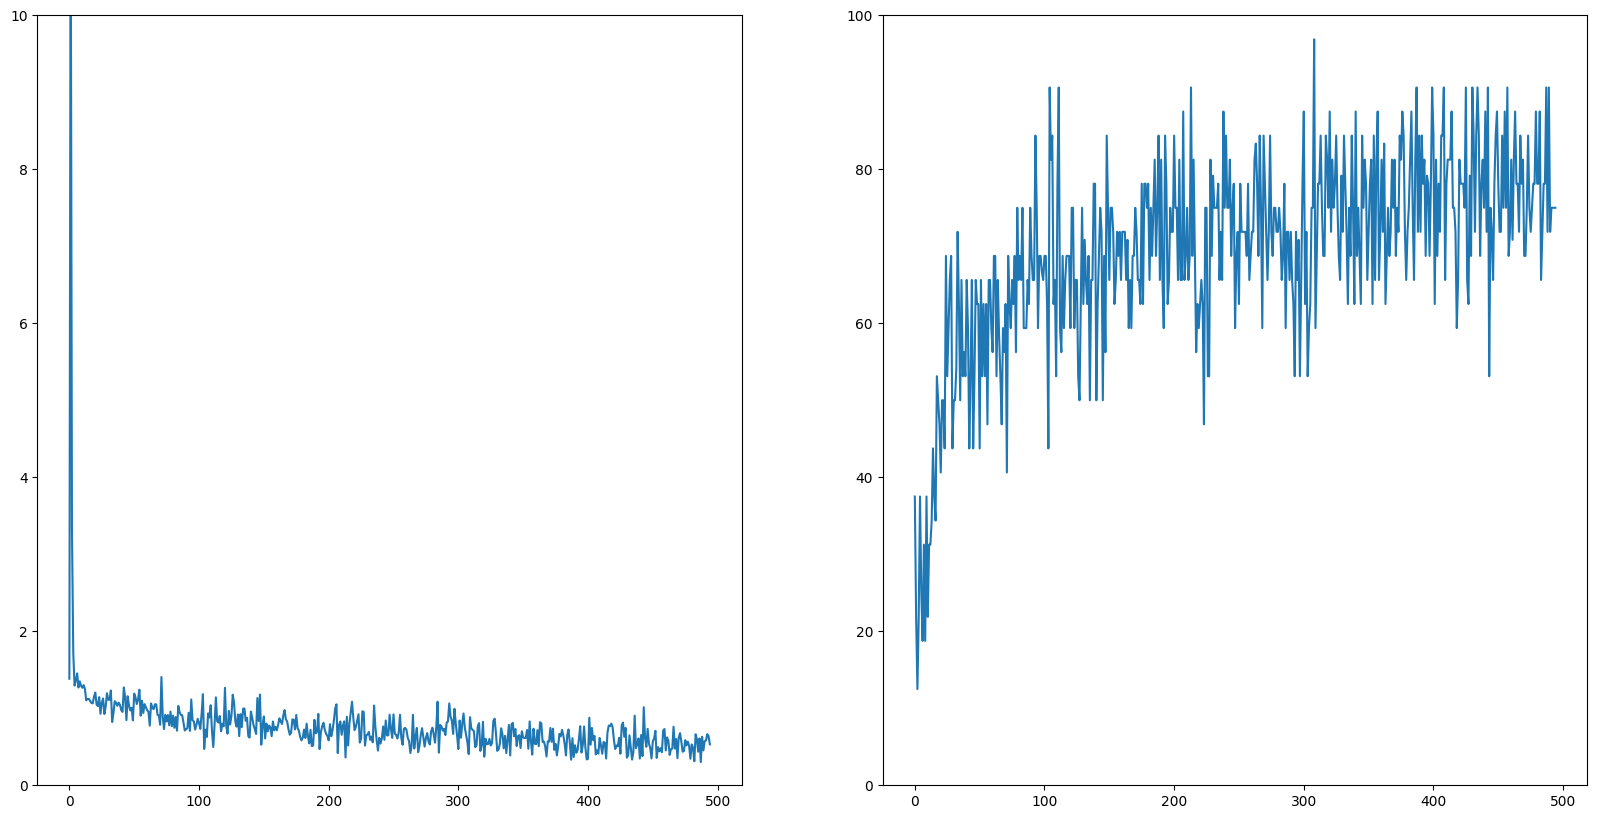

In [19]:
from matplotlib import pylab as plt
import numpy as np
plt.figure(figsize=(20,10))
plt.subplot(121), plt.plot(np.arange(len(train_cost)), train_cost), plt.ylim([0,10])
plt.subplot(122), plt.plot(np.arange(len(train_accu)), 100 * torch.as_tensor(train_accu).numpy()), plt.ylim([0,100])

In [20]:
main_y_test = []
main_p = []

In [22]:
model.eval()    # set the model to evaluation mode (dropout=False)

test_loader = torch.utils.data.DataLoader(dataset=test,batch_size=128)

for (batch_X, batch_Y) in test_loader:
    X_test = Variable(batch_X).cuda()
    Y_test = Variable(batch_Y).cuda()

    prediction = model(X_test).cuda()

    main_y_test.append(Y_test)
    main_p.append(prediction)
    # Compute accuracy
    correct_prediction = (torch.max(prediction.data, dim=1)[1] == Y_test.data)
    accuracy = correct_prediction.float().mean().item()
    print('\nAccuracy: {:2.2f} %'.format(accuracy*100))
    break


Accuracy: 83.59 %


In [23]:
from matplotlib import pylab as plt

plt.figure(figsize=(15,15), facecolor='white')
for i in torch.arange(0,12):
    val, idx = torch.max(prediction, dim=1)
    plt.subplot(4,4,int(i+1))
    plt.imshow(X_test[i][0].cpu())
    plt.title('This is class: '+test.classes[idx[i].item()])
    plt.xticks([]), plt.yticks([])
    plt.plt.subplots_adjust()

In [24]:
from sklearn.metrics import  confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=0.5, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)

    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20)
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0)

    # Plot confusion matrix
    plt.show()

    return

In [25]:
y_test = []

for main_yt in main_y_test:
  for yt in main_yt:
    y_test.append(yt.item())

In [26]:
prediction[0]

tensor([-3.1622, -0.0762, -3.5711, -5.8447], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [27]:
y_pred = []

for yp in main_p:
  for yt in yp:
    y_pred.append(np.argmax(list(yt.cpu().detach().numpy())))

In [28]:
cm = confusion_matrix(y_test, y_pred)

In [29]:
cm

array([[67,  1, 11,  2],
       [ 1, 40,  2,  4],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0]])

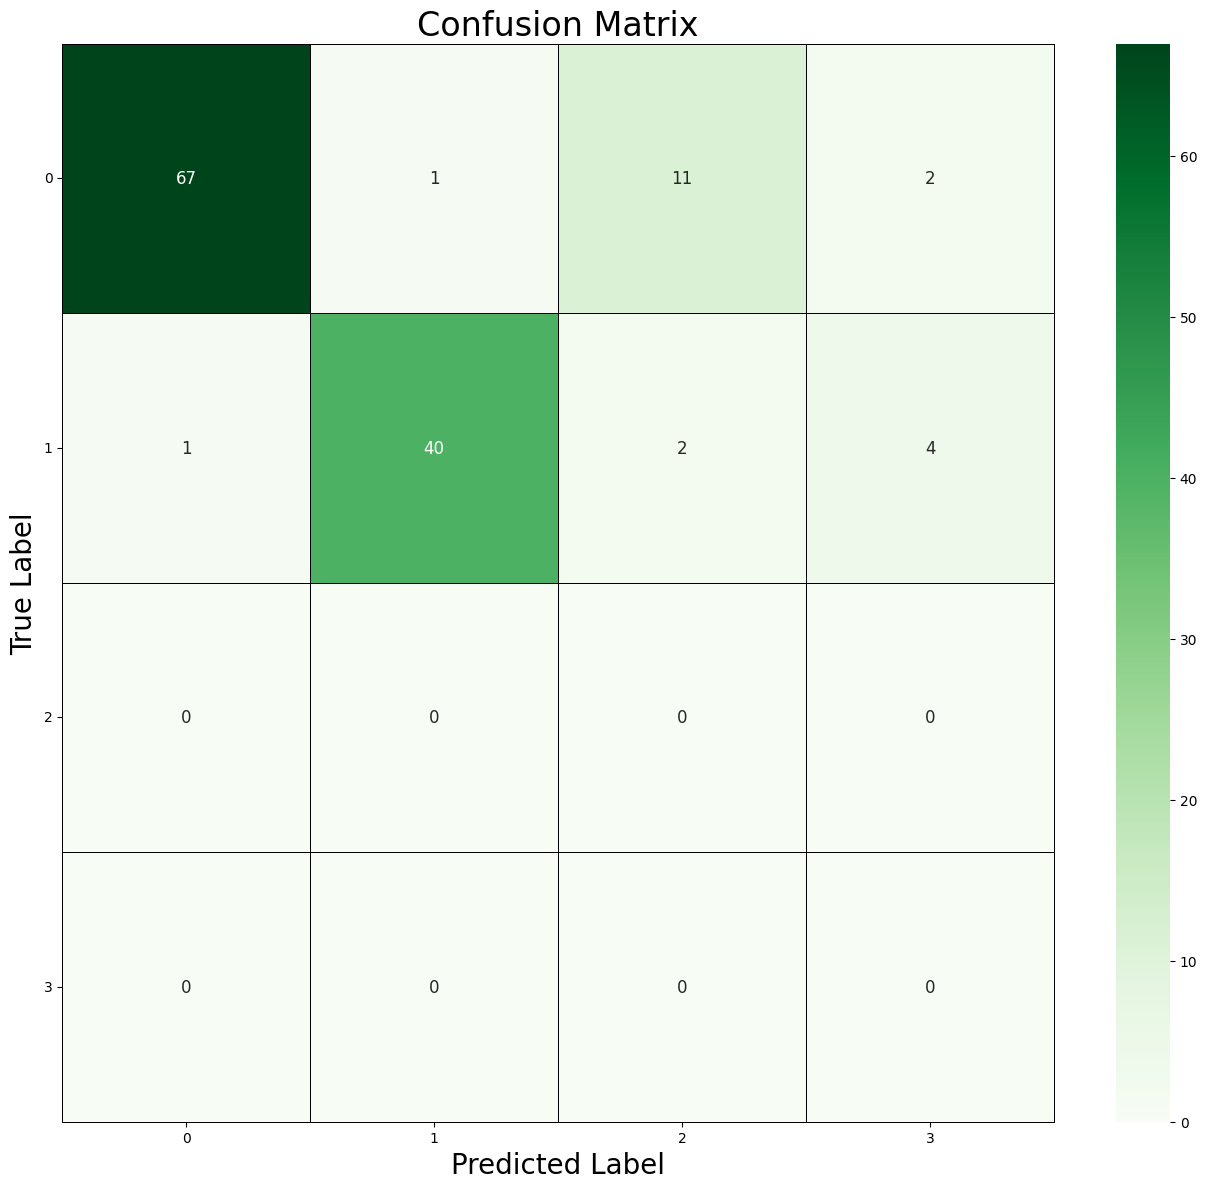

In [30]:

plot_confusion_matrix(
    y_test,
    y_pred,
    figsize=(16, 14),
    classes=['0','1','2','3'])

In [31]:
print(
    classification_report(
        y_test,
        y_pred,
        target_names=['0','1','2','3']
))

              precision    recall  f1-score   support

           0       0.99      0.83      0.90        81
           1       0.98      0.85      0.91        47
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.84       128
   macro avg       0.49      0.42      0.45       128
weighted avg       0.98      0.84      0.90       128



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


photo_2024-01-08_19-33-23.jpg